# Buscar arroz

## Preparar bibliotecas e constantes

In [1]:
%matplotlib inline

import os
import numpy as np
import cv2

from matplotlib import pyplot as plt

GAMMA = 10
RESIZE = 1

## Abrir nossa imagem

In [2]:
imgs = ['60.bmp', '82.bmp', '114.bmp', '150.bmp', '205.bmp']
IMG_NAME = imgs[4]
try:
    img = cv2.cvtColor(cv2.imread("input/" + IMG_NAME), cv2.COLOR_BGR2RGB)
except:
    exit(1)
img_w, img_h, img_c = img.shape

## Tratar imagem

A correção gama será realizada para realçar os detalhes dos arroz, normalmente brancos, e homogenizar levemente o fundo em tons escuros.

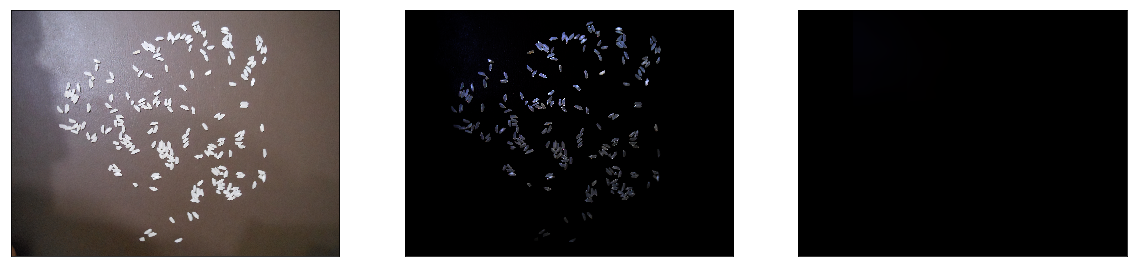

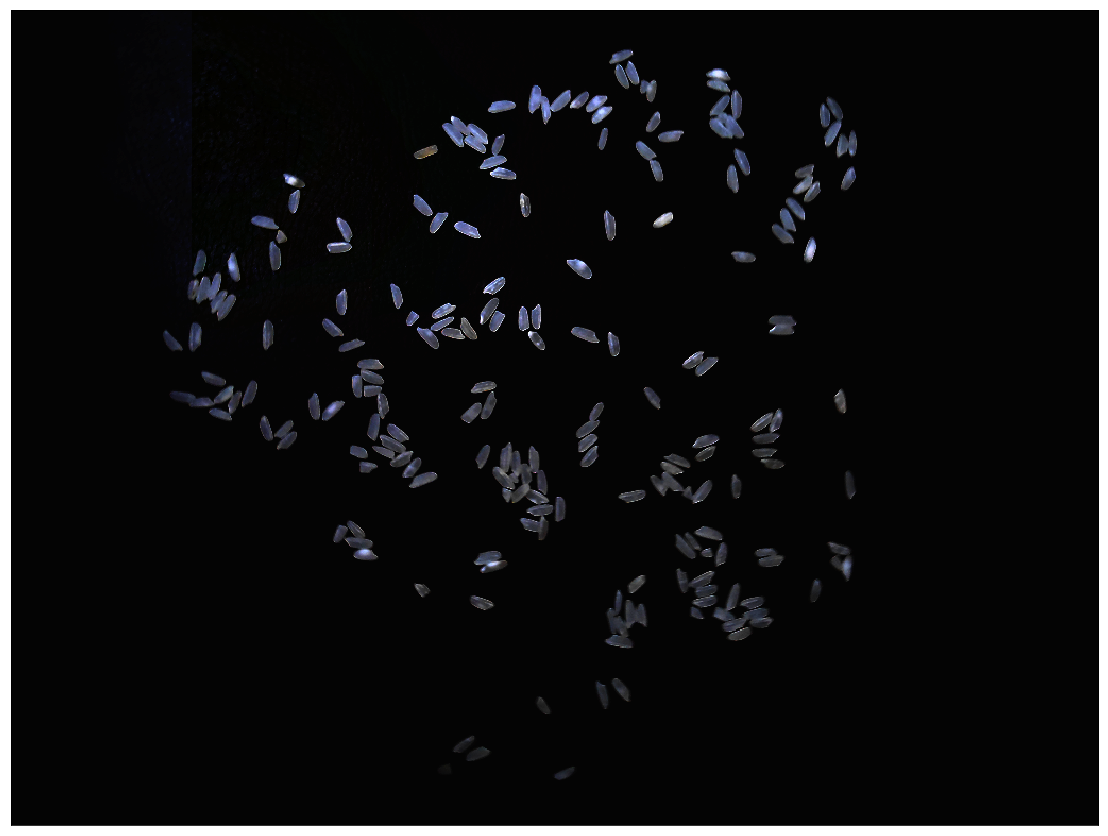

In [3]:
# Copiar a imagem original
simg = img.copy()

# Criar o plot
fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharex=True, sharey=True)
plt.xticks([]), plt.yticks([])

# Imagem original
axes[0].imshow(img)
plt.xticks([]), plt.yticks([])

# Correção Gama
def correcaoGama(img):
    return np.uint8(((np.float32(img / 255) ** GAMMA) * 255))

simg = correcaoGama(simg)
axes[1].imshow(simg)

# Nitidez
def aumentarNitidez(img):
    sharpness = cv2.medianBlur(img, RESIZE * 70 + 1)
    cv2.addWeighted(sharpness, -1.3, img, 0.7, 3, img)
    img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return img, sharpness

simg, sharpness = aumentarNitidez(simg)
axes[2].imshow(sharpness)

plt.show()

# Ver resultado final
fig, axes = plt.subplots(1, 1, figsize=(25, 15), sharex=True, sharey=True)
axes.imshow(simg)
plt.xticks([]), plt.yticks([])
plt.show()

## Binarizar

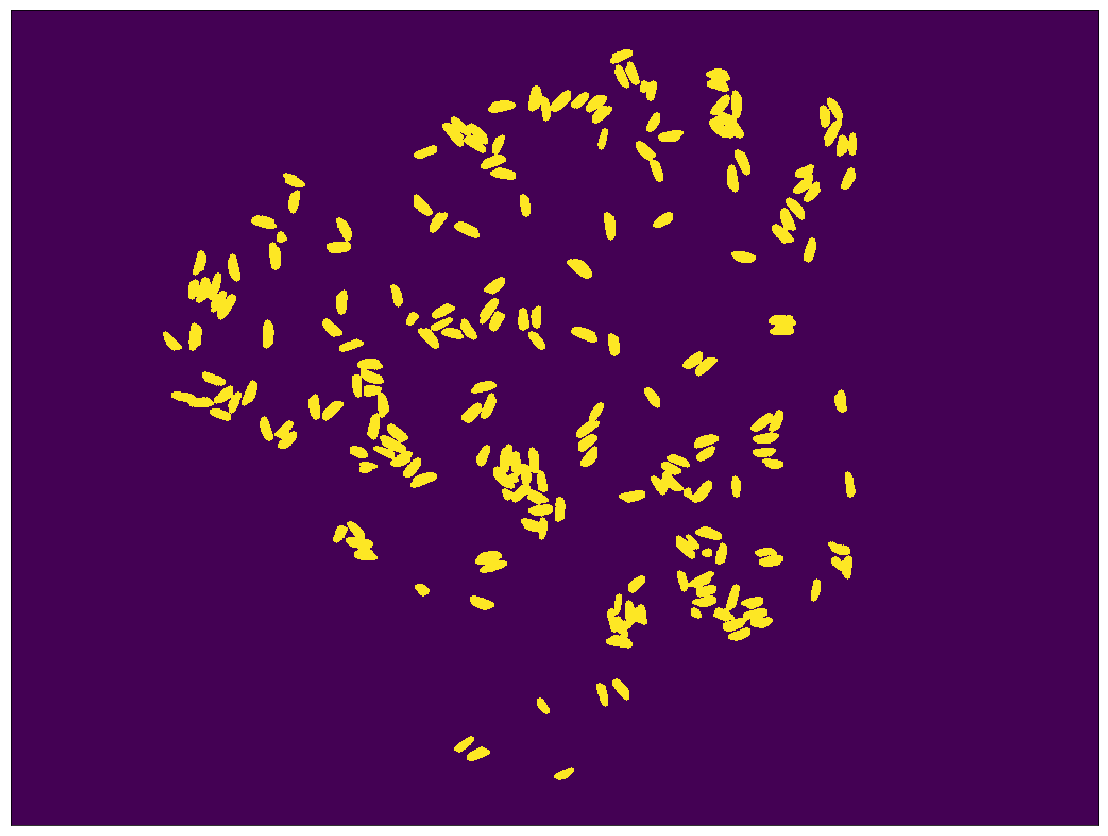

In [4]:
# Escala de cinza
gsimg = cv2.cvtColor(simg, cv2.COLOR_BGR2GRAY)

# Threshold adaptativo
bimg = cv2.adaptiveThreshold(gsimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 251, -10)
bimg = np.uint8(np.where(bimg == 0, 255, 0))

# Limpar ruidos
bimg = cv2.morphologyEx(bimg, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)), iterations=1)

# Ver resultado final
fig, axes = plt.subplots(1, 1, figsize=(25, 15), sharex=True, sharey=True)
axes.imshow(bimg)
plt.xticks([]), plt.yticks([])
plt.show()

# Resultados

## Encontrar componentes

In [5]:
ret, labels = cv2.connectedComponents(bimg)
ngohan_enct = np.max(labels)

## Tamanho das componentes

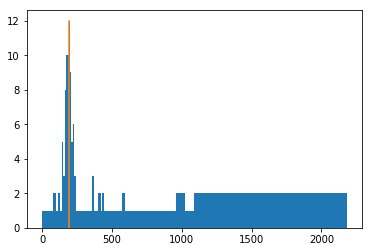

In [6]:
comp_size = np.zeros(ngohan_enct)

for i in range(1, ngohan_enct):
    comp_size[i] = (int((labels == i).sum() / 10)) * 10

bins = np.unique(comp_size)
hstack_labelsize = np.hstack(comp_size)
n, bins, patches = plt.hist(hstack_labelsize, bins=bins)

tam_arroz = np.unique(comp_size)[n.argmax()]

aux_x = bins[n.argmax()]
plt.plot([aux_x, aux_x], [0, n.max()])
plt.show()

## Componentes encontradas x Tamanho em pixel

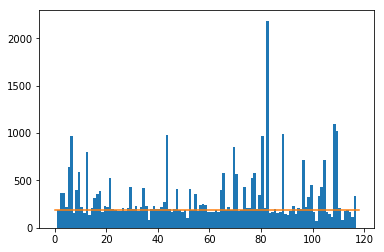

In [7]:
# Mostrar resultado
a = np.hstack(labels)
plt.hist(a, bins=range(1, ngohan_enct))
plt.plot([0, ngohan_enct], [tam_arroz, tam_arroz])
plt.show()

In [8]:
# Verificar cada componente e seu tamanho
ngohan_sepa = 0
for i in range(1, ngohan_enct):
    
    # Tamanho da componente
    label_size = np.sum(np.where(labels == i, 1, 0))
    
    # Quantos arroz entrariam nessa componente
    contar = int(label_size / tam_arroz)
    if contar > 0:
        ngohan_sepa += contar
    else:
        ngohan_sepa += 1
        continue
    
    # Faltou pouco para mais um arroz?
    if (label_size % tam_arroz) / tam_arroz > 0.6:
        ngohan_sepa += 1

print("Arroz encontrados: " + str(ngohan_enct))
print("Arroz estimados: "   + str(ngohan_sepa))
print("Arroz esperados: "   + os.path.splitext(IMG_NAME)[0])

Arroz encontrados: 118
Arroz estimados: 196
Arroz esperados: 205
